In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import random


pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns', 50)

students=pd.read_csv('stud_math.csv')
# переименуем столбец
students=students.rename(columns={'studytime, granular': 'granular'})
students.tail()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0
394,MS,M,19,U,LE3,T,1.0,1.0,other,at_home,NaN,father,1.0,1.0,0.0,NaN,no,no,no,yes,-3.0,yes,yes,no,3.0,2.0,3.0,5.0,5.0,45.0


In [63]:
# Используемые функции
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score',data=students)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

#### В датафрейме 395 строк и 30 столбцов. Пройдемся по каждому столбцу и проверим на наличие пустых значений, выбросов и некорректной информации.

In [64]:
# school Пропуски и некорректные данные отсутсвуют
display(students.school.describe())
display(students.school.value_counts())

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

GP    349
MS     46
Name: school, dtype: int64

In [65]:
# sex Пропуски и некорректные данные отсутсвуют
display(students.sex.describe())
display(students.sex.value_counts())

count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

F    208
M    187
Name: sex, dtype: int64

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

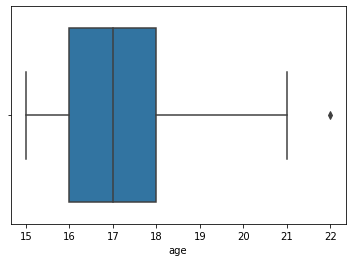

In [66]:
# age все строки заполнены но присутствует один выброс. 
# Т.к. в задани указаны учащиеся 15-22 лет, то не считаем это значение выбросом
# и оставляем его.
display(students.age.describe())
display(students.age.value_counts())
age=sns.boxplot(x=students['age'])

In [67]:
# address
students.address.value_counts(dropna=False)

U      295
R       83
NaN     17
Name: address, dtype: int64

#### В столбце address уже встречаются 17 пропусков. Прежде чем думать что с ними делать думаю стоит посмотреть есть ли в этих строчках еще пропуски. А лучше проверить весь датафрейм на наличие пропусков и удалить те строчки где встречаются 3 и более пропуска. Ну и удаляем строки с пропусками (если есть) в столбце score, т.к. это наша ключевая переменная. В итоге посмотрим каой части информации мы лишимся.

In [68]:
students.dropna(thresh=28, inplace=True)
students.dropna(subset=['score'],inplace=True)
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 394
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      324 non-null    object 
 1   sex         324 non-null    object 
 2   age         324 non-null    int64  
 3   address     317 non-null    object 
 4   famsize     305 non-null    object 
 5   Pstatus     297 non-null    object 
 6   Medu        323 non-null    float64
 7   Fedu        310 non-null    float64
 8   Mjob        312 non-null    object 
 9   Fjob        304 non-null    object 
 10  reason      311 non-null    object 
 11  guardian    305 non-null    object 
 12  traveltime  314 non-null    float64
 13  studytime   324 non-null    float64
 14  failures    313 non-null    float64
 15  schoolsup   316 non-null    object 
 16  famsup      299 non-null    object 
 17  paid        300 non-null    object 
 18  activities  313 non-null    object 
 19  nursery     314 non-null    o

#### Осталось 324 строчки из 395. Т.е. мы потеряли примено 18% информации. Но это была информация с тремя и более пропусками, которые надо было бы чем то заполнять. Считаю это допустимый процент потери информации. Все оставшиеся пропуски буду заменять по смыслу на случайные, моду, или среднее в зависимости от столбца. 

In [69]:
# Не нашел как проверить ячейку на то что она пуста, варианты '', nan и другие
# почему то не работают. Поэтому заменю пропуски на empty и их уже буду находить.
students.fillna('empty',inplace=True)

In [70]:
#address соотношение между вариантами 77/21% и пропусков 2%
# заменим на случайные т.к. не думаю что 2% значений сильно повлияют на результат
display(students.address.value_counts())
students.address=students.address.apply(lambda x: random.choice(['U','R'])
                                        if x=='empty' else x)

U        248
R         69
empty      7
Name: address, dtype: int64

In [71]:
# famsize соотношение между вариантами 68/27% и пропусков 5%
# заменим на случайные т.к. пропусков многовато, да и абсолютного лидера среди 
# вариантов нет
display(students.famsize.value_counts())
students.famsize=students.famsize.apply(lambda x: random.choice(['LE3','GT3'])
                                        if x=='empty' else x)

GT3      218
LE3       87
empty     19
Name: famsize, dtype: int64

In [72]:
# Pstatus соотношение между вариантами 82/10% и пропусков 8%
# хоть пропусков и достаточно много но один вариант превышает второй в 8 раз
# логично предположить пропущеные значения повторяют моду, заменяем на моду
display(students.Pstatus.value_counts())
students.Pstatus=students.Pstatus.apply(lambda x: 'T' if x=='empty' else x)

T        266
A         31
empty     27
Name: Pstatus, dtype: int64

In [73]:
# Medu пропуск всего один, заменяем на случайное значение
display(students.Medu.value_counts())
students.Medu=students.Medu.apply(lambda x: random.choice([0,1,2,3,4])
                                        if x=='empty' else x)

4.0      107
3.0       83
2.0       83
1.0       47
0.0        3
empty      1
Name: Medu, dtype: int64

In [74]:
# Fedu пропуски составляют 4%, остальные варианты примерно распределены
# одинаково, пропуски заполняем случайными значениями
# присутсвует один выброс "40", т.к. значение похоже на ответ "4.0" то логично
# предположить что это опечатка при вводе данных, меняем на 4.0
display(students.Fedu.value_counts())
students.Fedu=students.Fedu.apply(lambda x: random.choice([0,1,2,3,4])
                                        if x=='empty' else x)

students.Fedu=students.Fedu.apply(lambda x: 4 if x==40 else x)

2.0      86
4.0      79
3.0      77
1.0      65
empty    14
0.0       2
40.0      1
Name: Fedu, dtype: int64

In [75]:
# Mjob т.к. работа не известна то пропуски просто заменю на other
display(students.Mjob.value_counts())
students.Mjob=students.Mjob.apply(lambda x: 'other' if x=='empty' else x)

other       109
services     84
at_home      48
teacher      44
health       27
empty        12
Name: Mjob, dtype: int64

In [76]:
# Fjob с пропусками поступим также, заменим на other
display(students.Fjob.value_counts())
students.Fjob=students.Fjob.apply(lambda x: 'other' if x=='empty' else x)

other       159
services     91
teacher      28
empty        20
at_home      13
health       13
Name: Fjob, dtype: int64

In [77]:
# reason пропуски также заменяем на other
display(students.reason.value_counts())
students.reason=students.reason.apply(lambda x: 'other' if x=='empty' else x)

course        111
home           86
reputation     86
other          28
empty          13
Name: reason, dtype: int64

In [78]:
# guardian здесь думаю пропуски будет логичнее заменить на случайные между
# mother и father
display(students.guardian.value_counts())
students.guardian=students.guardian.apply(lambda x: random.choice(['mother', 'father'])
                                        if x=='empty' else x)

mother    213
father     72
other      20
empty      19
Name: guardian, dtype: int64

In [79]:
# traveltime здесь пропуски думаю заменить на случайные среди первых двух
# ответов, т.к. они составляют 90% всех ответов
display(students.traveltime.value_counts())
students.traveltime=students.traveltime.apply(lambda x: random.choice([1,2])
                                        if x=='empty' else x)

1.0      207
2.0       84
3.0       18
empty     10
4.0        5
Name: traveltime, dtype: int64

In [80]:
# studytime с этим столбцом все в порядке, пропусков и некорректных данных нет
display(students.studytime.value_counts())

2.0    159
1.0     85
3.0     55
4.0     25
Name: studytime, dtype: int64

In [81]:
# failures здесь пропуски думаю заменить на моду т.е. 0, т.к. этот вариант 
# составляет 78% от всех ответов
display(students.failures.value_counts())
students.failures=students.failures.apply(lambda x: 0 if x=='empty' else x)

0.0      251
1.0       39
2.0       12
empty     11
3.0       11
Name: failures, dtype: int64

In [82]:
# schoolsup здесь проуски также мнеяем на популярный ответ "no" который
# составляет 85% от всех ответов
display(students.schoolsup.value_counts())
students.schoolsup=students.schoolsup.apply(lambda x: 'no' if x=='empty' else x)

no       275
yes       41
empty      8
Name: schoolsup, dtype: int64

In [83]:
# famsup здесь разница в ответах на такая большая 58/34%, поэтому меняем на 
# случайные ответы
display(students.famsup.value_counts())
students.famsup=students.famsup.apply(lambda x: random.choice(['yes','no'])
                                        if x=='empty' else x)

yes      188
no       111
empty     25
Name: famsup, dtype: int64

In [84]:
# paid т.к. абсолютного лидера среди вариантов ответов нет, пропуски также 
# меняем на случайные 
display(students.paid.value_counts())
students.paid=students.paid.apply(lambda x: random.choice(['yes','no'])
                                        if x=='empty' else x)

no       172
yes      128
empty     24
Name: paid, dtype: int64

In [85]:
# activities пропуски также меняем на случайные
display(students.activities.value_counts())
students.activities=students.activities.apply(lambda x: random.choice(['yes','no'])
                                        if x=='empty' else x)

yes      159
no       154
empty     11
Name: activities, dtype: int64

In [86]:
# nursery популярный ответ составляет 78% а пропуски занимают всего 3%
#  меняем пропуски на моду
display(students.nursery.value_counts())
students.nursery=students.nursery.apply(lambda x: 'yes' if x=='empty' else x)

yes      252
no        62
empty     10
Name: nursery, dtype: int64

In [87]:
# granular этого столбца нет в описании датасета, не понятно что он отражает
# исключаем его из рассмотрения
display(students.granular.value_counts())
students.drop(['granular'], axis='columns', inplace=True)

-6.0     159
-3.0      85
-9.0      55
-12.0     25
Name: granular, dtype: int64

In [88]:
# higher пропуски меняем на моду, т.к. она абсолютный лидер по ответам 
display(students.higher.value_counts())
students.higher=students.higher.apply(lambda x: 'yes' if x=='empty' else x)

yes      297
no        15
empty     12
Name: higher, dtype: int64

In [89]:
# internet с пропусками поступаем аналогичным образом сто и с предыдущим столбцом
display(students.internet.value_counts())
students.internet=students.internet.apply(lambda x: 'yes' if x=='empty' else x)

yes      251
no        47
empty     26
Name: internet, dtype: int64

In [90]:
# romantic т.к. соотношение не большое, пропуски меняем на случайные 
display(students.romantic.value_counts())
students.romantic=students.romantic.apply(lambda x: random.choice(['yes','no'])
                                        if x=='empty' else x)

no       200
yes      109
empty     15
Name: romantic, dtype: int64

In [91]:
# famrel здесь пропуски думаю заменить на случайные среди первых трех 
# популярных ответов. Один некорректный ответ заменим на моду
display(students.famrel.value_counts())
students.famrel=students.famrel.apply(lambda x:random.choice([4,5,3])
                                        if x=='empty' else x)
students.famrel=students.famrel.apply(lambda x: 4
                                        if x==-1 else x)

4.0      149
5.0       81
3.0       53
empty     17
2.0       16
1.0        7
-1.0       1
Name: famrel, dtype: int64

In [92]:
# freetime пропуски заменим на случайные среди первых трех популярных ответов
display(students.freetime.value_counts())
students.freetime=students.freetime.apply(lambda x:random.choice([3,4,2])
                                        if x=='empty' else x)

3.0      129
4.0       94
2.0       54
5.0       27
1.0       16
empty      4
Name: freetime, dtype: int64

In [93]:
# пропусков мало, заменяем на случайные
display(students.goout.value_counts())
students.goout=students.goout.apply(lambda x:random.choice([3,2,4,5,1])
                                        if x=='empty' else x)

3.0      108
2.0       79
4.0       70
5.0       41
1.0       21
empty      5
Name: goout, dtype: int64

In [94]:
# health пропуски меняем на случайные
display(students.health.value_counts())
students.health=students.health.apply(lambda x:random.choice([5,3,4,2,1])
                                        if x=='empty' else x)

5.0      111
3.0       76
4.0       53
2.0       39
1.0       37
empty      8
Name: health, dtype: int64

In [95]:
# absences, здесь уже интереснее
# заменим пропуски на случайные популярные ответы
# ответы больше 20 являются выбросами но вот стоит ли их исключать?
# думаю надо исключить тех у кого большое количество пропусков например больше 
# 30 и при этом высокая оценка на экзамене например больше 40,
# хоть это могут быть и реальные случаи но они скорее исключение из правила
# а мы пытаемся выявить общую для всех закономерность

display(students.absences.value_counts())
students.absences=students.absences.apply(lambda x:random.choice([i for i in range(0,10)])
                                        if x=='empty' else x)
students.drop(students[(students.absences>30) & 
                       (students.score>40)].index,inplace=True)


0.0      93
2.0      46
4.0      44
6.0      25
8.0      18
10.0     15
12.0     11
14.0      9
16.0      7
empty     6
3.0       6
7.0       6
5.0       5
1.0       3
18.0      3
9.0       3
20.0      3
22.0      2
15.0      2
13.0      2
75.0      1
385.0     1
212.0     1
56.0      1
21.0      1
23.0      1
24.0      1
25.0      1
26.0      1
28.0      1
38.0      1
40.0      1
19.0      1
54.0      1
17.0      1
Name: absences, dtype: int64

In [96]:
# score, тут только привлекает занчения 0, в условия задания нет описания выставления 
# оценки, т.е. не понятно 0 получили те кто не я явился на экзамен или кто абсолютно ничего не 
# знал. В любом случае нам эти данные не подходят, т.к. явка на экзамен не цаль исследования, а 
# среднестатистические учащиеся которые посещали занятия и в итоге ничего не знали это
# исключение из правила, что тоже нам не подходит. Поэтому исключаем тех кто получил 0 на экзамене.
display(students.score.value_counts())
students.drop(students[students.score==0].index,inplace=True)


50.0     42
55.0     37
0.0      31
40.0     27
60.0     27
70.0     26
65.0     25
75.0     24
45.0     24
80.0     13
30.0     12
90.0      9
35.0      7
25.0      5
95.0      5
85.0      3
100.0     1
20.0      1
Name: score, dtype: int64

In [97]:
# В итоге наш датасет получился таким
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      288 non-null    object 
 1   sex         288 non-null    object 
 2   age         288 non-null    int64  
 3   address     288 non-null    object 
 4   famsize     288 non-null    object 
 5   Pstatus     288 non-null    object 
 6   Medu        288 non-null    float64
 7   Fedu        288 non-null    float64
 8   Mjob        288 non-null    object 
 9   Fjob        288 non-null    object 
 10  reason      288 non-null    object 
 11  guardian    288 non-null    object 
 12  traveltime  288 non-null    float64
 13  studytime   288 non-null    float64
 14  failures    288 non-null    float64
 15  schoolsup   288 non-null    object 
 16  famsup      288 non-null    object 
 17  paid        288 non-null    object 
 18  activities  288 non-null    object 
 19  nursery     288 non-null    o

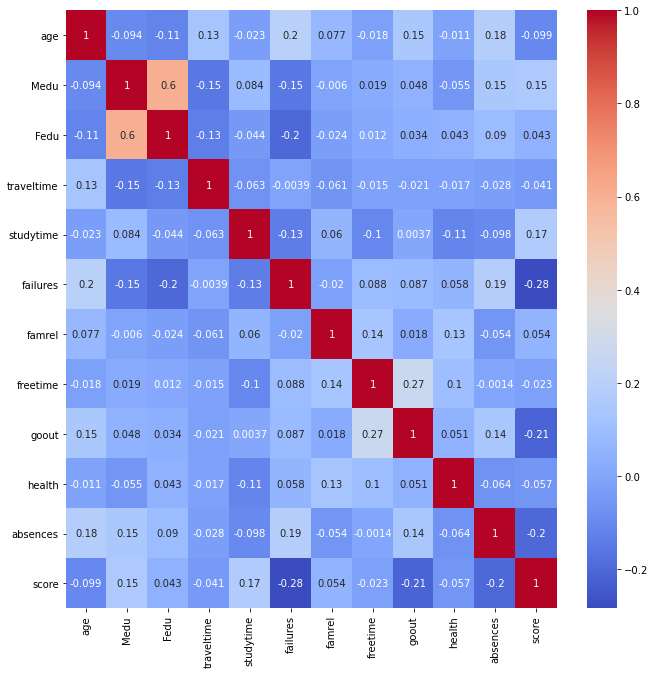

In [98]:
# построим тепловую карту
correlation = students.corr()
sns.heatmap(correlation,annot=True, cmap='coolwarm')
fig=plt.gcf()
fig.set_size_inches(11,11)

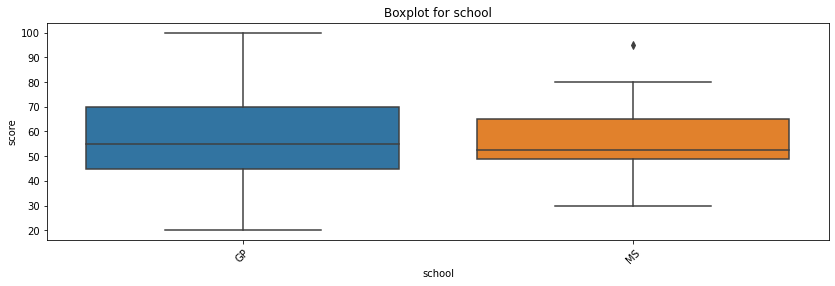

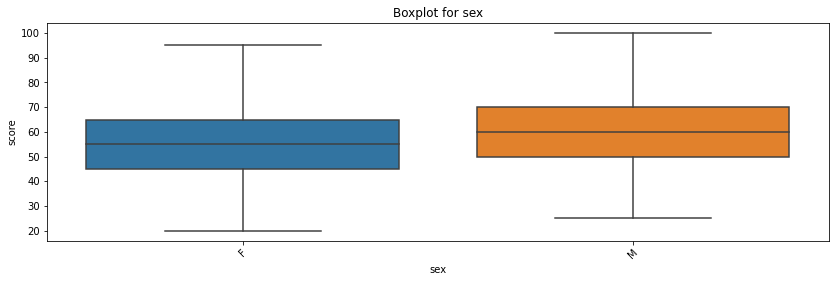

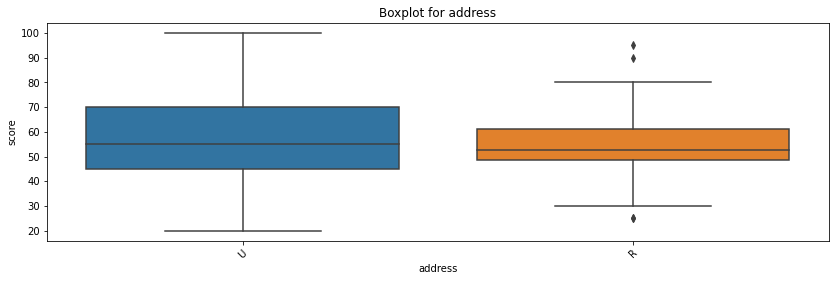

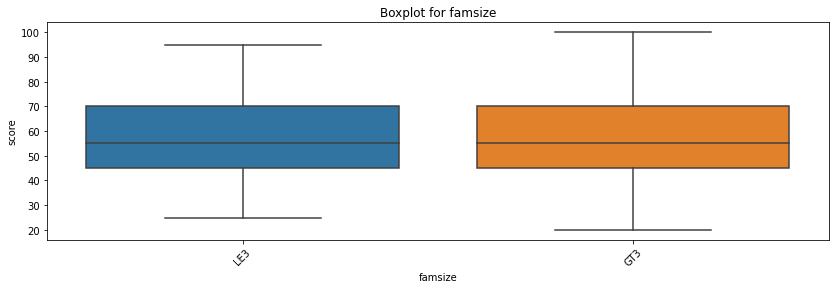

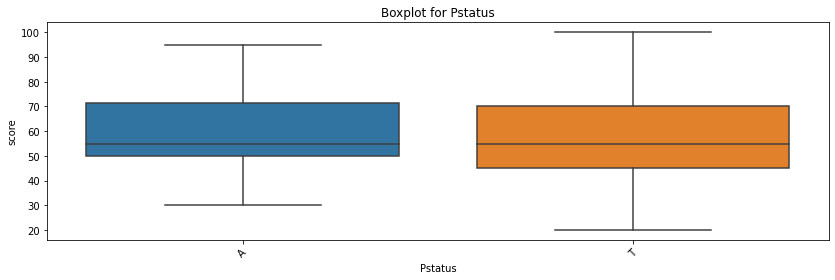

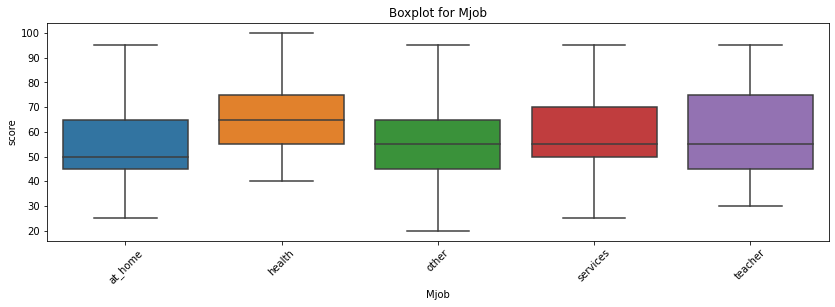

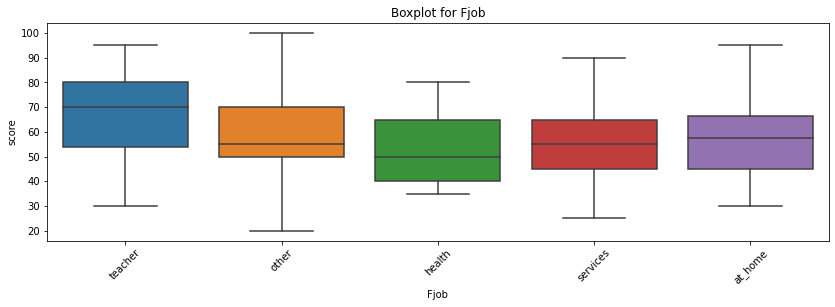

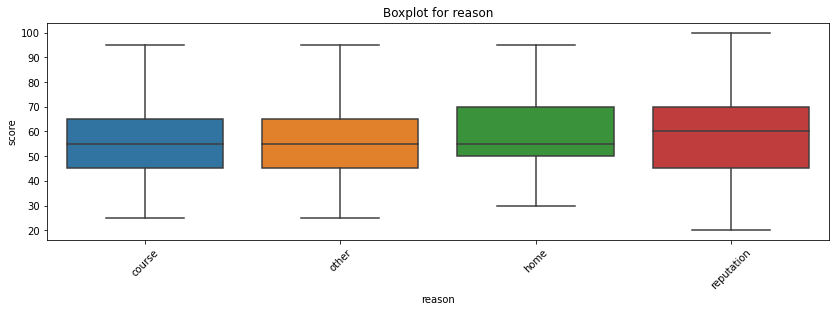

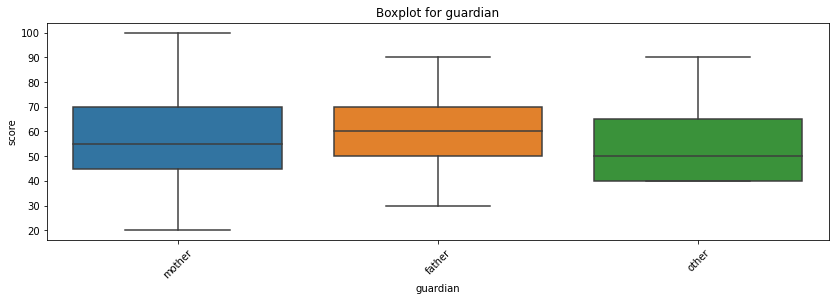

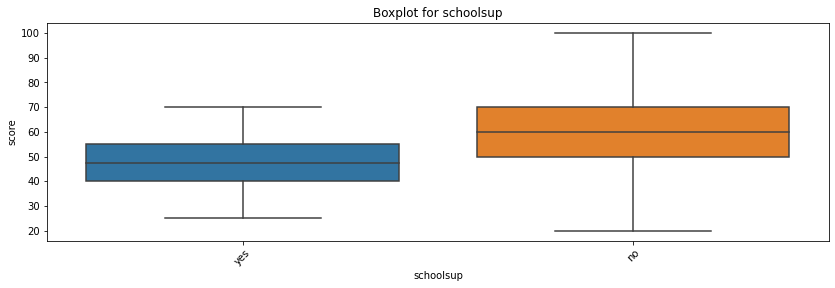

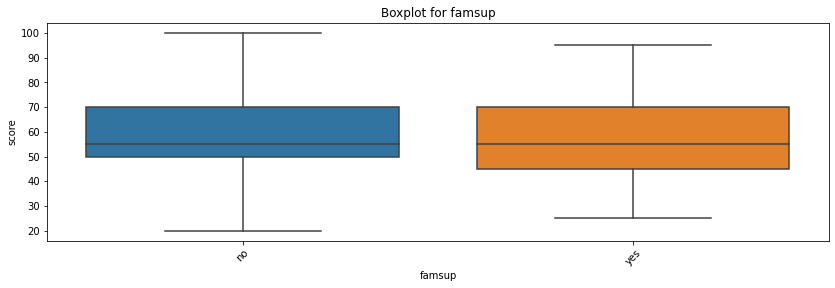

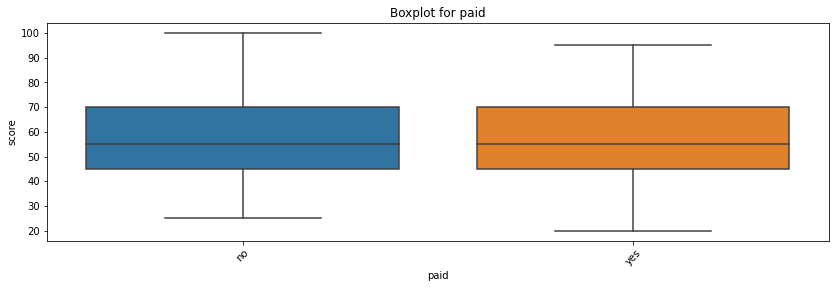

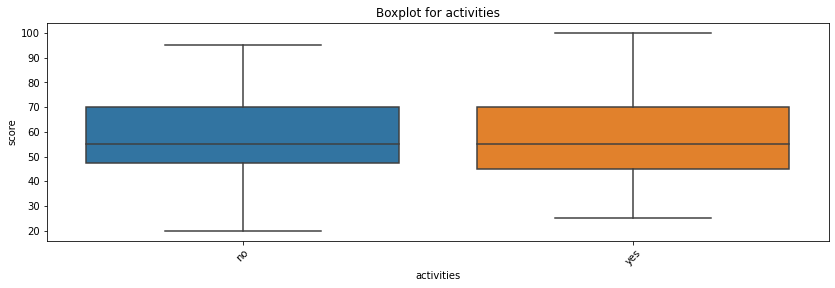

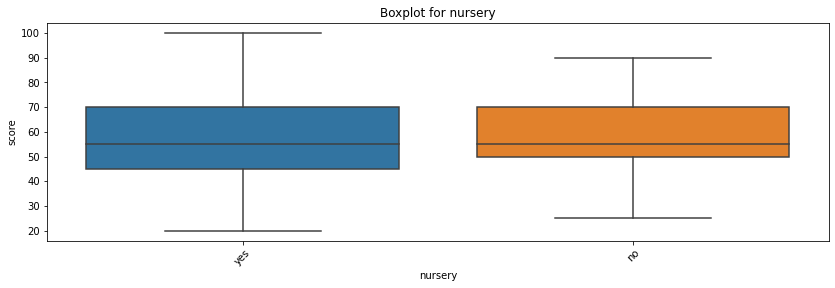

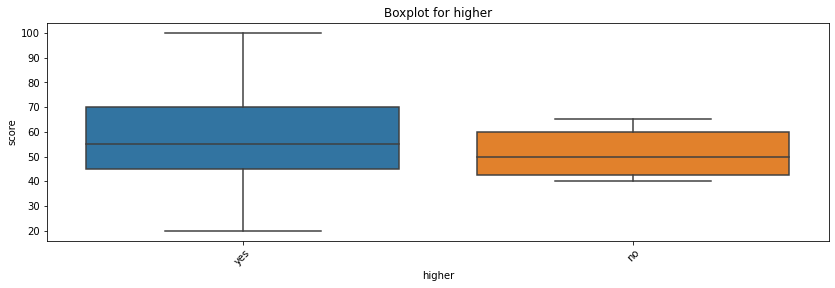

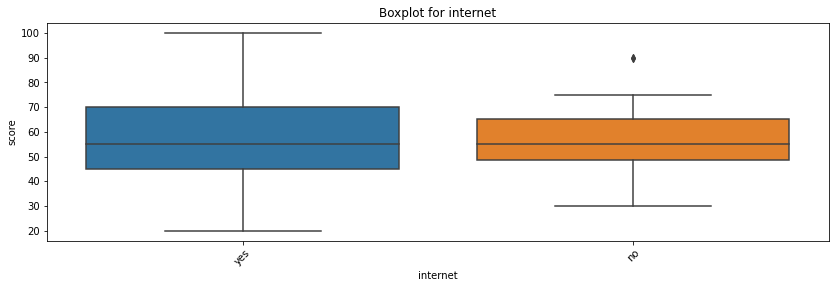

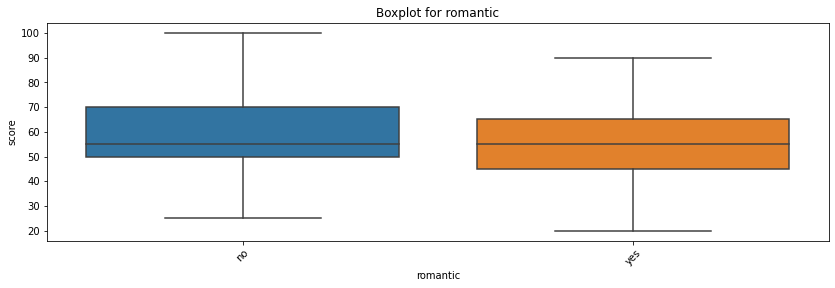

In [99]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus','Mjob','Fjob','reason','guardian',
           'schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']:
    get_boxplot(col)

#### Выводы: Предложенный датасет содержал много пропусков. После удаления строк с 3 и более пропусками а также удаления некорректной информации из целевого столбца score у нас осталось 73% информации от изначального датасета. Я считаю это приемлимой цифрой. Оставшиеся пропуски были заменены по смыслу для каждого столбца. Для количественных переменных построили тепловую карту из которой видно максимальная корреляция есть между столбцами Fedu и Medu, но считаю что это не достаточно чтоб удалять какой нибудь столбец.Остальные признаки коррелируют до значения 0,2. Т.е. все признаки оставляем.  Для номинативных переменных построили боксплоты из которых видно что признаки famsize, paid и activities (что  странно) имеют примерно одинаковые коробки, т.е. учащиеся получают примерно одинаковые оценки вне зависимости от размера семьи, дополнительных платных занятий и дополнительных внеучебных занятий. Этому вижу только одно объяснение, учащиеся без способностей к математике за счет дополнительный занятий дотягивают по знаниям до средних учащихся. Без этих дополнительных занятий эти учащиеся вероятно получали бы оценки ниже чем остальные. 